In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils

%load_ext autoreload
%autoreload 2

In [2]:
df_ranking = pd.read_csv('./data/2018_ranking.csv')
df_ranking = utils.polish_ranking_data(df_ranking)
df_ranking.head()

,Rank,Team,Score
0,1,Germany,1544
1,2,Brazil,1384
2,3,Belgium,1346
3,4,Portugal,1306
4,5,Argentina,1254


In [3]:
### normalization factor: average of the team-by-team difference
diffs = []
for i,row in df_ranking.query('Score > 0').iterrows():
    diffs += np.abs(df_ranking[ (df_ranking['Score']>0) & (df_ranking['Rank']>=row['Rank']) ]['Score'] - row['Score']).tolist()

diff_average = np.mean(diffs)
diff_max = np.max(diffs)
diff_average, diff_max

(356.7346747338305, 1540)

In [4]:
df_results = pd.read_csv('./data/2018_results.csv')
df_results.head()

,Team1,Result,Team2
0,Colombia,1:2,Japan
1,Poland,1:2,Senegal
2,Japan,2:2,Senegal
3,Poland,0:3,Colombia
4,Japan,0:1,Poland


In [5]:
team_to_score = df_ranking.set_index('Team')['Score'].to_dict()

# Combine FIFA scores for a match

In [6]:
d = []
g = []

for i,row in df_results.iterrows():

    t1_fifa_score = team_to_score.get(row['Team1'],0)
    t2_fifa_score = team_to_score.get(row['Team2'],0)

    match_result = [ int(i) for i in row['Result'].split(':') ]

    ## team 1
    diff = t1_fifa_score-t2_fifa_score
    d.append(diff)
    g.append( match_result[0] )

    ## team 2
    diff = t2_fifa_score-t1_fifa_score
    d.append(diff)
    g.append( match_result[1] )

df_to_fit = pd.DataFrame({
    'score_diff':d,
    'goals':g})
df_to_fit.head(10)

,score_diff,goals
0,461,1
1,-461,2
2,303,1
3,-303,2
4,-297,2
5,297,2
6,139,0
7,-139,3
8,-600,0
9,600,1


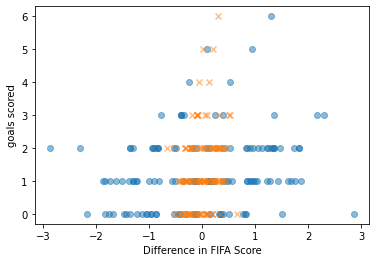

In [7]:
plt.figure()

plt.scatter(df_to_fit['score_diff']/diff_average, df_to_fit['goals'], label='norm to ave', alpha=.5)
plt.scatter(df_to_fit['score_diff']/diff_max, df_to_fit['goals'], label='norm to max', marker='x', alpha=.5)
#plt.scatter(utils.logistic(df_to_fit['score_diff']/diff_max), df_to_fit['goals'], label='logistic(d/max)', marker='x', alpha=.5)
#plt.scatter(utils.logistic(df_to_fit['score_diff']/diff_average), df_to_fit['goals'], label='logistic(d/ave)', marker='x', alpha=.5)

plt.xlabel('Difference in FIFA Score');
plt.ylabel('goals scored');

In [8]:
df_to_fit['score_diff_norm_ave'] = df_to_fit['score_diff'] / diff_average
df_to_fit['score_diff_norm_max'] = df_to_fit['score_diff'] / diff_max
df_to_fit['logit_score_diff_norm_ave'] = utils.logistic(df_to_fit['score_diff_norm_ave'])
df_to_fit['logit_score_diff_norm_max'] = utils.logistic(df_to_fit['score_diff_norm_max'])

In [9]:
df_to_fit['score_diff_norm_ave_bins'] = pd.cut(df_to_fit['score_diff_norm_ave'], bins=np.arange(-4.5,4.6,.5), include_lowest=False)
df_to_fit['logit_score_diff_norm_ave_bins'] = pd.cut(df_to_fit['logit_score_diff_norm_ave'], bins=np.arange(0,1.01,.1), include_lowest=False)

In [10]:
x_to_use = 'logit_score_diff_norm_ave'
bins_to_use = f'{x_to_use}_bins'
bins_center = f'{bins_to_use}_center'
d = df_to_fit.groupby(bins_to_use).agg({'goals':np.mean}).reset_index()
d[bins_center] = d[bins_to_use].apply( lambda x: x.mid)
d.head()

,logit_score_diff_norm_ave_bins,goals,logit_score_diff_norm_ave_bins_center
0,"(0.0, 0.1]",2.000000,0.05
1,"(0.1, 0.2]",0.454545,0.15
2,"(0.2, 0.3]",0.913043,0.25
3,"(0.3, 0.4]",1.272727,0.35
4,"(0.4, 0.5]",1.529412,0.45


[0.43693151 1.13720734]


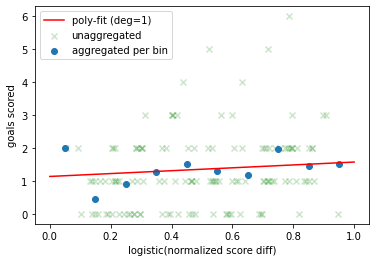

In [11]:
plt.figure()

plt.scatter(df_to_fit[x_to_use], df_to_fit['goals'], label='unaggregated', alpha=.2, marker='x', color='green')
plt.scatter(d[bins_center], d['goals'], label='aggregated per bin', alpha=1)

deg = 1
p = np.polyfit(d[bins_center], d['goals'], deg)
print(p)

x = np.linspace(0,1,100)
y = np.zeros(len(x))
for i,pi in enumerate(p):
    y += pi * x**(deg-i)

plt.plot(x, y, label=f'poly-fit (deg={deg})', color='red')

plt.xlabel('logistic(normalized score diff)');
plt.ylabel('goals scored');
#plt.ylim([-0.2,10]);
plt.legend(loc='best');

# "Calibrate"
The outcome of the above part is used to run simulations in the other notebook. Let's now tune the parameters of the simulation to make it more solid.

In [12]:
def get_winner(row, team_to_score):
    
    fifa_scores = [team_to_score.get(row['Team1']), team_to_score.get(row['Team2'])]
    result = [int(i) for i in row['Result'].split(':')]
    
    idx_win = np.argmax(result)
    idx_lose = 1 - idx_win
    
    if result[0]==result[1]:
        return 'draw'
    
    if fifa_scores[idx_win] > fifa_scores[idx_lose]:
        return 'best'
    return 'worse'

In [13]:
df_results['winner'] = df_results.apply( lambda r: get_winner(r, team_to_score), axis=1 )
df_results.head()

,Team1,Result,Team2,winner
0,Colombia,1:2,Japan,worse
1,Poland,1:2,Senegal,worse
2,Japan,2:2,Senegal,draw
3,Poland,0:3,Colombia,worse
4,Japan,0:1,Poland,best


In [14]:
x = df_results['winner'].value_counts()
x / x.sum()

best     0.515625
worse    0.281250
draw     0.203125
Name: winner, dtype: float64

In [15]:
config = {
    'score_name': 'Score',
    'normalization_factor': diff_average,
    'n_trials': 5000,
    'to_lambdas': lambda x: x * 2.5
}

In [16]:
simulation = []

for i,row in df_results.iterrows():
    
    o = utils.simulate_match(
        (row['Team1'],row['Team2']),
        df_ranking,
        **config
    )
    simulation.append(o)

df_sim = utils.extract(simulation)
df_sim.head()

,teams,normalized_score_diff,goals,probabilities,p_best_wins,p_worst_wins,p_draw
0,"[Japan, Colombia]",1.292277,"[[1, 3], [1, 1], [0, 5], [0, 2], [1, 0], [1, 1...","[0.0942, 0.1866, 0.7192]",0.7192,0.0942,0.1866
1,"[Senegal, Poland]",0.849371,"[[1, 2], [1, 1], [0, 2], [0, 1], [2, 3], [1, 1...","[0.1576, 0.2346, 0.6078]",0.6078,0.1576,0.2346
2,"[Japan, Senegal]",0.832552,"[[1, 1], [0, 3], [3, 0], [0, 3], [0, 2], [2, 2...","[0.1498, 0.2394, 0.6108]",0.6108,0.1498,0.2394
3,"[Colombia, Poland]",0.389645,"[[1, 1], [1, 3], [0, 0], [1, 1], [2, 1], [1, 3...","[0.2528, 0.272, 0.4752]",0.4752,0.2528,0.2720
4,"[Japan, Poland]",1.681922,"[[0, 4], [1, 6], [0, 2], [1, 1], [0, 1], [0, 3...","[0.0564, 0.164, 0.7796]",0.7796,0.0564,0.1640


In [17]:
df_results.head()

,Team1,Result,Team2,winner
0,Colombia,1:2,Japan,worse
1,Poland,1:2,Senegal,worse
2,Japan,2:2,Senegal,draw
3,Poland,0:3,Colombia,worse
4,Japan,0:1,Poland,best


In [18]:
df_results['teams-str'] = ''

for i,row in df_results.iterrows():
    df_results.at[i, 'teams-str'] = '-'.join(np.sort([row['Team1'],row['Team2']]))

df_sim['teams-str'] = ''
for i,row in df_sim.iterrows():
    df_sim.at[i, 'teams-str'] = '-'.join(np.sort(row['teams']))

In [19]:
df_results.head()

,Team1,Result,Team2,winner,teams-str
0,Colombia,1:2,Japan,worse,Colombia-Japan
1,Poland,1:2,Senegal,worse,Poland-Senegal
2,Japan,2:2,Senegal,draw,Japan-Senegal
3,Poland,0:3,Colombia,worse,Colombia-Poland
4,Japan,0:1,Poland,best,Japan-Poland


In [20]:
df_sim = df_sim.merge(df_results[['teams-str','winner']], on='teams-str')
df_sim.head()

,teams,normalized_score_diff,goals,probabilities,p_best_wins,p_worst_wins,p_draw,teams-str,winner
0,"[Japan, Colombia]",1.292277,"[[1, 3], [1, 1], [0, 5], [0, 2], [1, 0], [1, 1...","[0.0942, 0.1866, 0.7192]",0.7192,0.0942,0.1866,Colombia-Japan,worse
1,"[Senegal, Poland]",0.849371,"[[1, 2], [1, 1], [0, 2], [0, 1], [2, 3], [1, 1...","[0.1576, 0.2346, 0.6078]",0.6078,0.1576,0.2346,Poland-Senegal,worse
2,"[Japan, Senegal]",0.832552,"[[1, 1], [0, 3], [3, 0], [0, 3], [0, 2], [2, 2...","[0.1498, 0.2394, 0.6108]",0.6108,0.1498,0.2394,Japan-Senegal,draw
3,"[Colombia, Poland]",0.389645,"[[1, 1], [1, 3], [0, 0], [1, 1], [2, 1], [1, 3...","[0.2528, 0.272, 0.4752]",0.4752,0.2528,0.2720,Colombia-Poland,worse
4,"[Japan, Poland]",1.681922,"[[0, 4], [1, 6], [0, 2], [1, 1], [0, 1], [0, 3...","[0.0564, 0.164, 0.7796]",0.7796,0.0564,0.1640,Japan-Poland,best


best 0.4998342857142857
draw 0.4339076923076923
worse 0.345


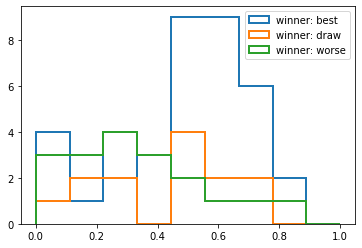

In [21]:
opt = {
    'bins':np.linspace(0,1,10),
    'histtype':'step',
    'lw':2
}
plt.figure()

for n,g in df_sim.groupby('winner'):
    delta = g['p_best_wins']-g['p_worst_wins']
    plt.hist( delta, label=f'winner: {n}', **opt )
    
    print(n, delta.mean())

plt.legend(loc='best');